# Tratamiento de datos COVID-10
## Objeto
Se tratarán los datos de la [Johns Hopkins](https://github.com/CSSEGISandData/COVID-19) que se suponen en el directorio data/COVID-19

## Comprobación de que los ficheros están donde se les espera

In [2]:
! ls data/COVID-19/csse_covid_19_data/csse_covid_19_time_series

Errata.csv
README.md
time_series_covid19_confirmed_global.csv
time_series_covid19_confirmed_US.csv
time_series_covid19_deaths_global.csv
time_series_covid19_deaths_US.csv
time_series_covid19_recovered_global.csv


## Importación de datos
Lo primero es común a todos los programas que traten datos

In [8]:
%matplotlib inline
import pandas as pd
import numpy as np

Se utiliza Pandas para leer el fichero csv. Las columnas que notienen datos (las 4 primeras), se ponen de índice. 

Se van a leer los datos de fallecimientos y de casso confirmados

In [105]:
df_deaths = pd.read_csv("data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", index_col=[0,1,2,3])
df_confirmed = pd.read_csv("data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", index_col=[0,1,2,3])

In [104]:
df_deaths.head()

1/22/20  1/23/20  1/24/20  \
Province/State Country/Region Lat       Long                                   
NaN            Afghanistan     33.93911 67.709953        0        0        0   
               Albania         41.15330 20.168300        0        0        0   
               Algeria         28.03390 1.659600         0        0        0   
               Andorra         42.50630 1.521800         0        0        0   
               Angola         -11.20270 17.873900        0        0        0   

                                                   1/25/20  1/26/20  1/27/20  \
Province/State Country/Region Lat       Long                                   
NaN            Afghanistan     33.93911 67.709953        0        0        0   
               Albania         41.15330 20.168300        0        0        0   
               Algeria         28.03390 1.659600         0        0        0   
               Andorra         42.50630 1.521800         0        0        0   
               Angola         -11.20270 17.873900        0        0        0   

                                                   1/28/20  1/29/20  1/30/20  \
Province/State Country/Region Lat       Long                                   
NaN            Afghanistan     33.93911 67.709953        0        0        0   
               Albania         41.15330 20.168300        0        0        0   
               Algeria         28.03390 1.659600         0        0        0   
               Andorra         42.50630 1.521800         0        0        0   
               Angola         -11.20270 17.873900        0        0        0   

                                                   1/31/20  ...  12/24/20  \
Province/State Country/Region Lat       Long                ...             
NaN            Afghanistan     33.93911 67.709953        0  ...      2126   
               Albania         41.15330 20.168300        0  ...      1125   
               Algeria         28.03390 1.659600         0  ...      2705   
               Andorra         42.50630 1.521800         0  ...        83   
               Angola         -11.20270 17.873900        0  ...       393   

                                                   12/25/20  12/26/20  \
Province/State Country/Region Lat       Long                            
NaN            Afghanistan     33.93911 67.709953      2139      2149   
               Albania         41.15330 20.168300      1134      1143   
               Algeria         28.03390 1.659600       2716      2722   
               Andorra         42.50630 1.521800         83        83   
               Angola         -11.20270 17.873900       396       399   

                                                   12/27/20  12/28/20  \
Province/State Country/Region Lat       Long                            
NaN            Afghanistan     33.93911 67.709953      2160      2174   
               Albania         41.15330 20.168300      1153      1164   
               Algeria         28.03390 1.659600       2728      2737   
               Andorra         42.50630 1.521800         83        83   
               Angola         -11.20270 17.873900       399       403   

                                                   12/29/20  12/30/20  \
Province/State Country/Region Lat       Long                            
NaN            Afghanistan     33.93911 67.709953      2179      2181   
               Albania         41.15330 20.168300      1170      1174   
               Algeria         28.03390 1.659600       2745      2751   
               Andorra         42.50630 1.521800         84        84   
               Angola         -11.20270 17.873900       403       405   

                                                   12/31/20  1/1/21  1/2/21  
Province/State Country/Region Lat       Long                                 
NaN            Afghanistan     33.93911 67.709953      2191    2191    2191  
               Albania         41.15330 20.168300      118

In [106]:
df_confirmed.head()

1/22/20  1/23/20  1/24/20  \
Province/State Country/Region Lat       Long                                   
NaN            Afghanistan     33.93911 67.709953        0        0        0   
               Albania         41.15330 20.168300        0        0        0   
               Algeria         28.03390 1.659600         0        0        0   
               Andorra         42.50630 1.521800         0        0        0   
               Angola         -11.20270 17.873900        0        0        0   

                                                   1/25/20  1/26/20  1/27/20  \
Province/State Country/Region Lat       Long                                   
NaN            Afghanistan     33.93911 67.709953        0        0        0   
               Albania         41.15330 20.168300        0        0        0   
               Algeria         28.03390 1.659600         0        0        0   
               Andorra         42.50630 1.521800         0        0        0   
               Angola         -11.20270 17.873900        0        0        0   

                                                   1/28/20  1/29/20  1/30/20  \
Province/State Country/Region Lat       Long                                   
NaN            Afghanistan     33.93911 67.709953        0        0        0   
               Albania         41.15330 20.168300        0        0        0   
               Algeria         28.03390 1.659600         0        0        0   
               Andorra         42.50630 1.521800         0        0        0   
               Angola         -11.20270 17.873900        0        0        0   

                                                   1/31/20  ...  12/24/20  \
Province/State Country/Region Lat       Long                ...             
NaN            Afghanistan     33.93911 67.709953        0  ...     50655   
               Albania         41.15330 20.168300        0  ...     54827   
               Algeria         28.03390 1.659600         0  ...     97007   
               Andorra         42.50630 1.521800         0  ...      7699   
               Angola         -11.20270 17.873900        0  ...     17029   

                                                   12/25/20  12/26/20  \
Province/State Country/Region Lat       Long                            
NaN            Afghanistan     33.93911 67.709953     50810     50886   
               Albania         41.15330 20.168300     55380     55755   
               Algeria         28.03390 1.659600      97441     97857   
               Andorra         42.50630 1.521800       7756      7806   
               Angola         -11.20270 17.873900     17099     17149   

                                                   12/27/20  12/28/20  \
Province/State Country/Region Lat       Long                            
NaN            Afghanistan     33.93911 67.709953     51039     51280   
               Albania         41.15330 20.168300     56254     56572   
               Algeria         28.03390 1.659600      98249     98631   
               Andorra         42.50630 1.521800       7821      7875   
               Angola         -11.20270 17.873900     17240     17296   

                                                   12/29/20  12/30/20  \
Province/State Country/Region Lat       Long                            
NaN            Afghanistan     33.93911 67.709953     51350     51405   
               Albania         41.15330 20.168300     57146     57727   
               Algeria         28.03390 1.659600      98988     99311   
               Andorra         42.50630 1.521800       7919      7983   
               Angola         -11.20270 17.873900     17371     17433   

                                                   12/31/20  1/1/21  1/2/21  
Province/State Country/Region Lat       Long                                 
NaN            Afghanistan     33.93911 67.709953     51526   51526   51526  
               Albania         41.15330 20.168300     5831

## Tratamiento de datos
Se hace una agrupamiento por país (level=1) y una transposición de forma que los países aparezcan como columnas y los días como filas

In [108]:
deaths_covid = df_deaths.groupby(level=1).sum().transpose()
confirmed_covid = df_confirmed.groupby(level=1).sum().transpose()


In [109]:
deaths_covid.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [110]:
confirmed_covid.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,2,0,0,0,0


Los ficheros csv contienen cifras acumuladas. Vamos a ver los incrementos diarios con la función diff

In [111]:
deaths_covid_inc = deaths_covid.diff()
confirmed_covid_inc =confirmed_covid.diff()

In [112]:
deaths_covid_inc.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
1/22/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
confirmed_covid_inc.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
1/22/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/23/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1/24/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/25/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/26/20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Gráficos

Se obtienen gráficos para fallecimientos y casos confirmados muestreados por semanas (resampling = 'W') ya que se ha comprobado
que los datos presentan fuerte correlación con el día de la semana. De esta forma se evitan dientes de sierra.

Los países para los cuales se desean los gráficos están en el array interesting_countries.

El último dato es el de la fecha en la que se ejecuta el notebook (todate = today). El primero de los datos se pone a mano.
En una versión posterior podría ser un número de semanas o meses y hacer que fromdate sea today - datetime.timedelta(days=xx).por ejemplo.

La escala en y puede ser logarítimca (logaritmic = True) o no (logaritmic = False)

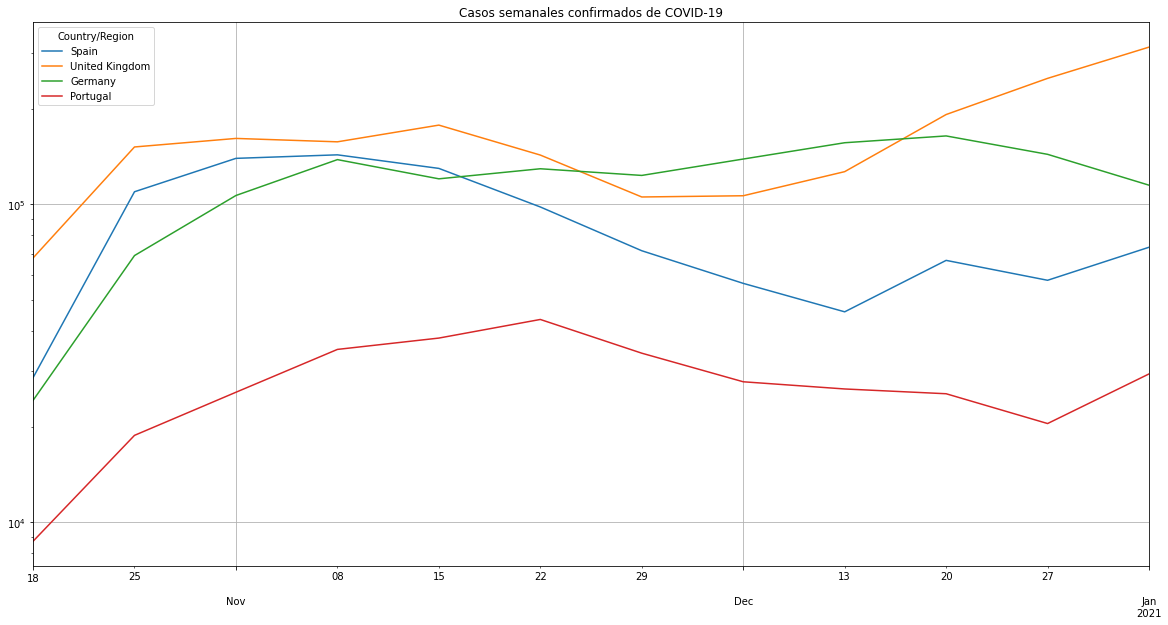

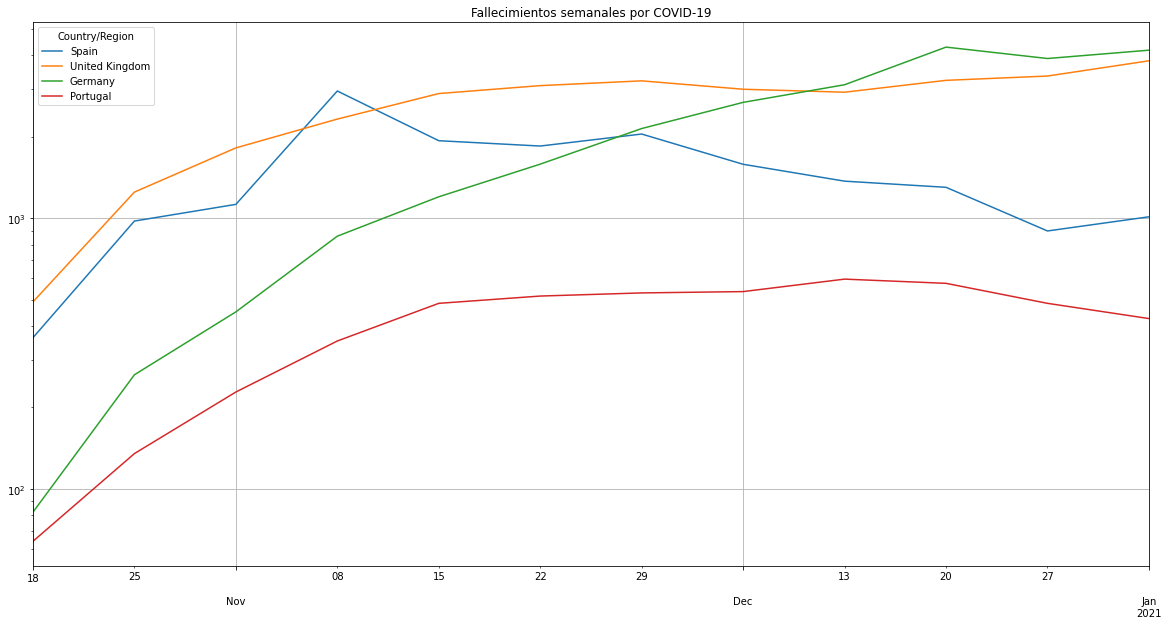

In [172]:
import datetime

deaths_covid_inc.index = pd.to_datetime(deaths_covid_inc.index)
confirmed_covid_inc.index = pd.to_datetime(confirmed_covid_inc.index)

#interesting_countries = ['Spain','France','United Kingdom', 'Chile', 'Germany']
interesting_countries = ['Spain','United Kingdom', 'Germany', 'Portugal']

fromdate='10/15/20'
today = datetime.date.today()
#yesterday = today - datetime.timedelta(days=1)
todate=today.strftime("%m/%d/%y")

resampling = 'W'
fsize = (20,10)
logaritmic = True

axc = confirmed_covid_inc[interesting_countries].loc[fromdate:todate].resample(resampling).sum().plot(title='Casos semanales confirmados de COVID-19', 
                                                                        figsize=fsize, 
                                                                        logy=logaritmic,
                                                                        grid=True
                                                                        )
axd = deaths_covid_inc[interesting_countries].loc[fromdate:todate].resample(resampling).sum().plot(title='Fallecimientos semanales por COVID-19', 
                                                                        figsize=fsize, 
                                                                        logy=logaritmic,
                                                                        grid=True                                                                      
                                                                       )